# Data exploration notebook
Please update the path_dataset variable in cell 3 to the path of the dataset in your local machine.

In [15]:
import os
import pandas as pd
import mne
import torch
import numpy as np
import soft_dtw

In [32]:
os.chdir('/home/pauli/self-supervised-learning-eeg')

In [34]:
path_dataset = './Dataset/EEG/EEG'

In [20]:
class Patient:
    def __init__(self, participant_id, gender, age, group, MMSE, eeg=None):
        self.participant_id = participant_id
        self.gender = gender
        self.age = age
        self.group = group
        self.MMSE = MMSE
        self.eeg = eeg # Raw EEG are of shape (2,19) Why 2 i don't know, 19 because we have 19 channels
        self.epochs = None

    def __repr__(self):
        return f"Patient(ID={self.participant_id}, Age={self.age}, Group={self.group}, MMSE={self.MMSE})"

In [21]:
def load_participants(file_path):
    # Read the tsv file into a pandas DataFrame
    participants_df = pd.read_csv(file_path, sep='\t')
    return participants_df


def load_eeg(participant_id, path_dataset=""):
    # Define the EEG file path
    eeg_file = os.path.join(path_dataset,'derivatives', participant_id, 'eeg', f"{participant_id}_task-eyesclosed_eeg.set")
    
    if os.path.exists(eeg_file):
        # Load the EEG data using mne library
        try:
            eeg_data = mne.io.read_raw_eeglab(eeg_file, preload=True)
            return eeg_data
        except Exception as e:
            print(f"Could not load EEG file for participant {participant_id}: {e}")
            return None
    else:
        print(f"EEG file for participant {participant_id} not found.")
        return None

In [22]:
def create_patients_list(participants_df, path_dataset=""):
    patients_list = []
    
    for index, row in participants_df.iterrows():
        participant_id = row['participant_id']
        gender = row['Gender']
        age = row['Age']
        group = row['Group']
        MMSE = row['MMSE']
        
        # Load the EEG file for this participant
        eeg = load_eeg(participant_id, path_dataset)
        
        # Create a Patient object
        patient = Patient(participant_id, gender, age, group, MMSE, eeg)
        
        # Append the Patient object to the list
        patients_list.append(patient)
        
    return patients_list

When executing the next cell, please ignore the "RuntimeWarning: The data contains 'boundary' events ..." warnings as those are accounted for later in the notebook.

In [35]:
participants_file = os.path.join(path_dataset,'participants.tsv')
    
# Load the participants data
participants_df = load_participants(participants_file) #Create the panda dataframe of the file.

# Create the patients list
patients_list = create_patients_list(participants_df, path_dataset)

/var/tmp/ipykernel_29493/726078517.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_data = mne.io.read_raw_eeglab(eeg_file, preload=True)
/var/tmp/ipykernel_29493/726078517.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_data = mne.io.read_raw_eeglab(eeg_file, preload=True)
/var/tmp/ipykernel_29493/726078517.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_data = mne.io.read_raw_eeglab(eeg_file, preload=True)
/var/tmp/ipykernel_29493/726078517.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_data = mne.io.read_raw_eeglab(eeg_file, preload=True)
/var/tmp/ipy

## Example function ##

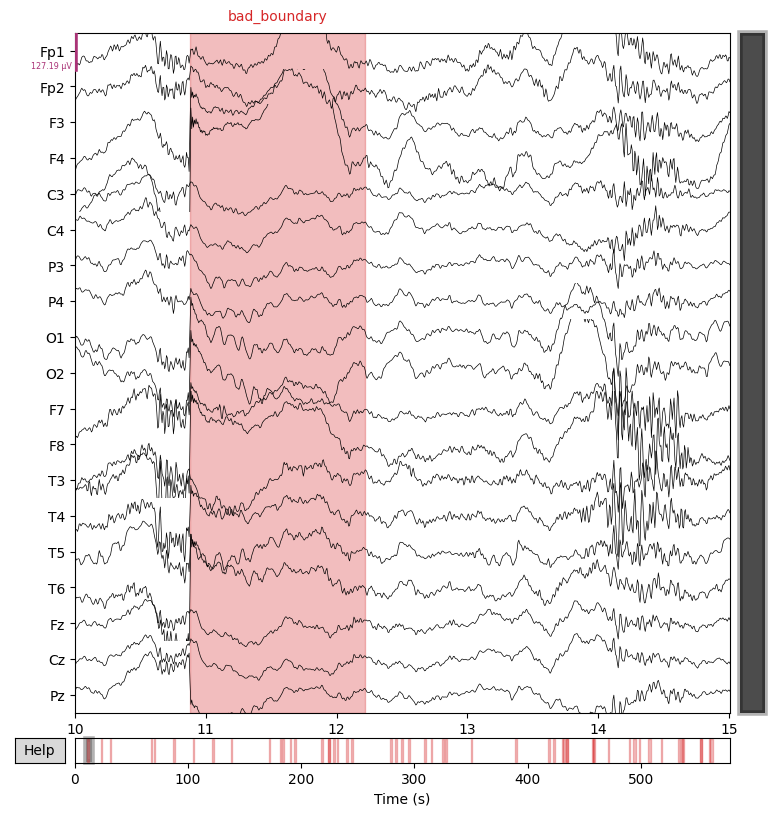

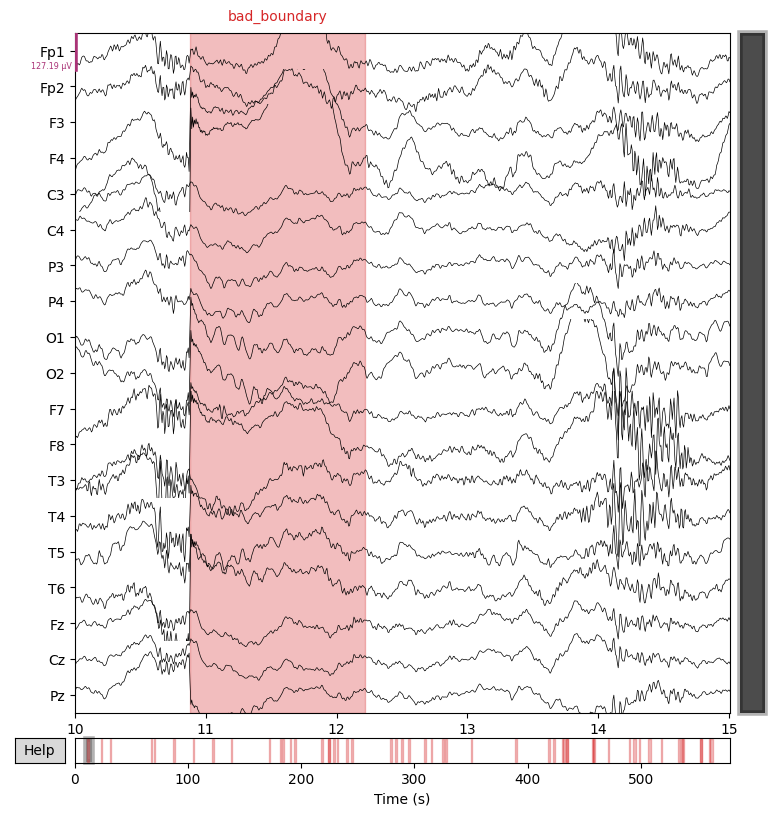

In [104]:
# Plot the channels
# The red zone represents the boundary in the recording
patients_list[85].eeg.plot(n_channels=19, duration=5, start=10.0, scalings='auto')

In [9]:
def filter_patients_by_group(patients_list, group):
    filtered_list = [patient for patient in patients_list if patient.group == group]
    return filtered_list

# Data exploration

## Boundaries

In the following cell, we observe that some participants have many boundary events (eg sub-086), while others have none. This is important to consider when splitting the recordings into epochs.

In [92]:
# To print boundaries for each patient
for patient in patients_list:
    for annot in patient.eeg.annotations:
        print(f"Subject {patient.participant_id}, onset: {annot['onset']}, duration: {annot['duration']}")

Subject sub-003, onset: 32.979, duration: 1.0
Subject sub-004, onset: 479.739, duration: 1.0
Subject sub-006, onset: 148.579, duration: 1.34
Subject sub-006, onset: 206.059, duration: 1.68
Subject sub-006, onset: 485.219, duration: 1.68
Subject sub-007, onset: 32.639, duration: 1.0
Subject sub-007, onset: 314.859, duration: 1.68
Subject sub-008, onset: 475.999, duration: 1.68
Subject sub-008, onset: 642.619, duration: 1.34
Subject sub-008, onset: 645.019, duration: 1.68
Subject sub-008, onset: 693.999, duration: 1.0
Subject sub-009, onset: 169.659, duration: 1.0
Subject sub-010, onset: 88.399, duration: 1.34
Subject sub-010, onset: 91.819, duration: 1.0
Subject sub-010, onset: 155.759, duration: 1.68
Subject sub-010, onset: 495.099, duration: 1.34
Subject sub-010, onset: 512.459, duration: 1.34
Subject sub-010, onset: 859.959, duration: 1.34
Subject sub-010, onset: 980.339, duration: 1.34
Subject sub-011, onset: 385.899, duration: 1.68
Subject sub-012, onset: 16.319, duration: 3.72
Sub

## Longest epoch
Extract length of longest continuous segment for each participant.

In [166]:
def boundary_stats(patient):
    eeg = patient.eeg
    nb_boundaries = len([annot for annot in eeg.annotations if annot['description'] == 'boundary'])
    nb_epochs = nb_boundaries + 1
    length_epochs = []  # List to store the length of each epoch
    t = 0
    for annot in eeg.annotations:
        if 'boundary' in annot['description']:
            length_epochs.append(annot['onset'] - t)
            t = annot['onset'] + annot['duration']
    length_epochs.append(eeg.times[-1] - t)
    longest_epoch = max(length_epochs)
    return nb_epochs, length_epochs, longest_epoch

In [167]:
# Compute the boundary statistics for each patient
all_nb_epochs = []
all_longest_epochs = []
for patient in patients_list:
    nb_epochs, length_epochs, longest_epoch = boundary_stats(patient)
    all_nb_epochs.append(nb_epochs)
    all_longest_epochs.append(longest_epoch)
# Add to participants_df
participants_df['nb_epochs'] = all_nb_epochs
participants_df['longest_epoch'] = all_longest_epochs

In [168]:
participants_df[participants_df['nb_epochs']>20]

,participant_id,Gender,Age,Group,MMSE,nb_epochs,longest_epoch
31,sub-032,F,59,A,20,35,131.28
39,sub-040,M,61,C,30,34,558.32
55,sub-056,F,64,C,30,57,178.20
85,sub-086,M,49,F,26,54,38.46


## Soft-DTW

### Split recordings into epochs

In [36]:
# Split recordings into epochs of a fixed duration and drop epochs overlapping with boundary annotations
def get_epochs(subject, 
               duration=30 #in seconds
               ):
    eeg = subject.eeg
    # Rename boundary annotations to bad_boundary to drop epochs overlapping with boundary annotations
    rename_dict = {'boundary': 'bad_boundary'}
    if 'boundary' in eeg.annotations.description:
        eeg.annotations.rename(rename_dict)
    # Create epochs
    epochs = mne.make_fixed_length_epochs(eeg, duration=duration, reject_by_annotation=True, preload=False, verbose=0)
    epochs.drop_bad(verbose=0)
    return epochs
    
# Downsample the EEG data to 100 Hz and create epochs of 10 seconds
for subject in patients_list:
    subject.eeg.resample(100)
    subject.epochs = get_epochs(subject, duration=10)

### Compute soft-DTW distance matrix

In [42]:
# Helper functions

def select_random_epoch(epochs, nb_epochs=1, seed=2024):
    np.random.seed(seed)
    random_indices = np.random.choice(len(epochs), nb_epochs, replace=False)
    random_epochs = epochs[random_indices]
    return random_epochs, random_indices

def compute_dtw_two_subjects(subject1, subject2, seed=2024):
    distance = soft_dtw.SoftDTW(gamma=0.1, normalize=True)
    if subject1.participant_id == subject2.participant_id:
        epochs = subject1.epochs
        # Randomly select two epochs
        epochs12, random_indices = select_random_epoch(epochs, 2, seed=seed)
        idx1, idx2 = random_indices
        epoch1 = epochs12[0]
        epoch2 = epochs12[1]
    else:
        # Get the epochs
        epochs1 = subject1.epochs
        epochs2 = subject2.epochs
        # Randomly select an epoch
        epoch1, idx1  = select_random_epoch(epochs1, 1, seed=seed)
        epoch2, idx2 = select_random_epoch(epochs2, 1, seed=seed)
    # Get the data
    data1 = epoch1.get_data()[:, :2]
    data2 = epoch2.get_data()[:, :2]
    # Prepare the data
    x = torch.tensor(data1).permute(0, 2, 1)
    y = torch.tensor(data2).permute(0, 2, 1)
    # Z normalize the data
    x = (x - x.mean(axis=1)) / x.std(axis=1)
    y = (y - y.mean(axis=1)) / y.std(axis=1)
    # Compute the DTW
    #dtw = distance(x,y).item()
    dtw=0
    return dtw, idx1.item(), idx2.item()

In [43]:
compute_dtw_two_subjects(patients_list[0], patients_list[1])

Using data from preloaded Raw for 1 events and 1500 original time points ...
Using data from preloaded Raw for 1 events and 1500 original time points ...


(0, 47, 3)

Next cell is long to run (~1h15), to run the following cells you can load the precomputed distance matrix in the cell after

In [44]:
'''# Compute the matrix of DTW distances between all pairs of subjects
%%capture
seed = 2024
distances = np.zeros((len(patients_list), len(patients_list)))
random_indices = np.zeros((len(patients_list), len(patients_list), 2))
for i, subject1 in enumerate(patients_list):
    for j, subject2 in enumerate(patients_list):
        dtw, idx1, idx2 = compute_dtw_two_subjects(subject1, subject2, seed=seed)
        distances[i, j] = dtw
        random_indices[i, j] = [idx1, idx2]'''

In [16]:
d = np.load('distances_seed_2024.npy')

In [17]:
# Mean distance intra subject
print(f"Mean distance intra subject: {np.mean([d[i, i] for i in range(len(patients_list))])}")

# Mean distance inter subject
inter_subject_distances = [d[i, j] for i in range(len(patients_list)) for j in range(len(patients_list)) if i != j]
print(f"Mean distance inter subject: {np.mean(inter_subject_distances)}")

# Mean distance per group
group_A = filter_patients_by_group(patients_list, 'A')
group_A_ids = [patient.participant_id for patient in group_A]
group_A_indices = [i for i, patient in enumerate(patients_list) if patient.participant_id in group_A_ids]
group_C = filter_patients_by_group(patients_list, 'C')
group_C_ids = [patient.participant_id for patient in group_C]
group_C_indices = [i for i, patient in enumerate(patients_list) if patient.participant_id in group_C_ids]
group_F = filter_patients_by_group(patients_list, 'F')
group_F_ids = [patient.participant_id for patient in group_F]
group_F_indices = [i for i, patient in enumerate(patients_list) if patient.participant_id in group_F_ids]

# Mean distance group A
group_A_distances = [d[i, j] for i in group_A_indices for j in group_A_indices if i != j]
print(f"Mean distance group A: {np.mean(group_A_distances)}")

# Mean distance group C
group_C_distances = [d[i, j] for i in group_C_indices for j in group_C_indices if i != j]
print(f"Mean distance group C: {np.mean(group_C_distances)}")

# Mean distance group F
group_F_distances = [d[i, j] for i in group_F_indices for j in group_F_indices if i != j]
print(f"Mean distance group F: {np.mean(group_F_distances)}")


Mean distance intra subject: 832.3584538156337
Mean distance inter subject: 831.8026856987454
Mean distance group A: 810.1321666112021
Mean distance group C: 818.3936676626722
Mean distance group F: 901.0604241412619


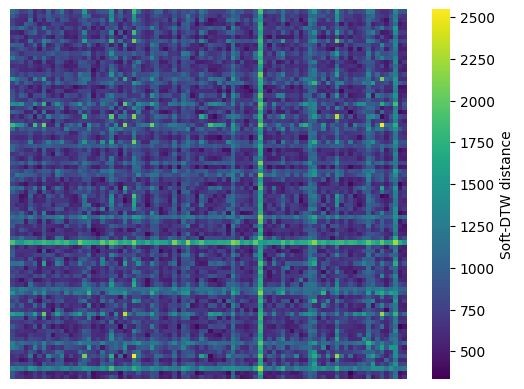

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(d, cmap='viridis', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Soft-DTW distance'}, )
plt.show()